In [1]:
# Bibliotecas python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
%matplotlib inline

# Função para calcular moda.
from scipy import stats

# Formatação dos gráficos
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend

In [2]:
# Configurando o tema do gráfico
myrcs = {"axes.titleweight": "bold", "lines.markersize": 9.0, "lines.linewidth": 2.0,}
sns.set (style="whitegrid", font_scale=1.25, rc=myrcs)

# Linhas exibidas por padrão nos dataframes
pd.options.display.min_rows = 20

In [3]:
# Parâmetros que variam nesta simulação
seeds = [10,20]
cargas = ["25hosts", "50hosts", "75hosts", "100hosts"]

# Tempo total de simulação
t_sim = 2000

In [4]:
# Função para ler os arquivos de log
def mymode (series):
    return stats.mode (series)[0]

agg_map = {'SwAtivosDepois' : np.mean, 'SwAtivosDepois' : np.mean, 'AvgCPULoad' : np.mean}

def read_dataframe ():
    df_slc = []
    for carga in cargas:
        df_sed = []
        for seed in seeds:
            df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-logDecisaoSwitchesSW.txt", sep='\s+', index_col=["Time"])
            df_sed.append (df)
        df_slc.append (pd.concat (df_sed).groupby (["Time"]).agg (agg_map))
    df_read = pd.concat (df_slc, keys=cargas, names=["Carga"], copy=False)
    return df_read.reset_index ()

In [5]:
df_plot = read_dataframe()
#df_plot

In [6]:
df_hw = []
agg_maphw = {'LoaUsag' : np.mean, 'FloUsag' : np.mean, 'FloEntr' : np.mean}
for carga in cargas:
    df_sed = []
    for seed in seeds:
        df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-switch-stats-hw.log", sep='\s+', index_col=["TimeSec"])
        df_sed.append (df)
    df_hw.append (pd.concat (df_sed).groupby (["TimeSec"]).agg (agg_maphw))
df_hwstats = pd.concat (df_hw, keys=cargas, names=["Carga"], copy=False)
df_hwstats = df_hwstats.reset_index ()

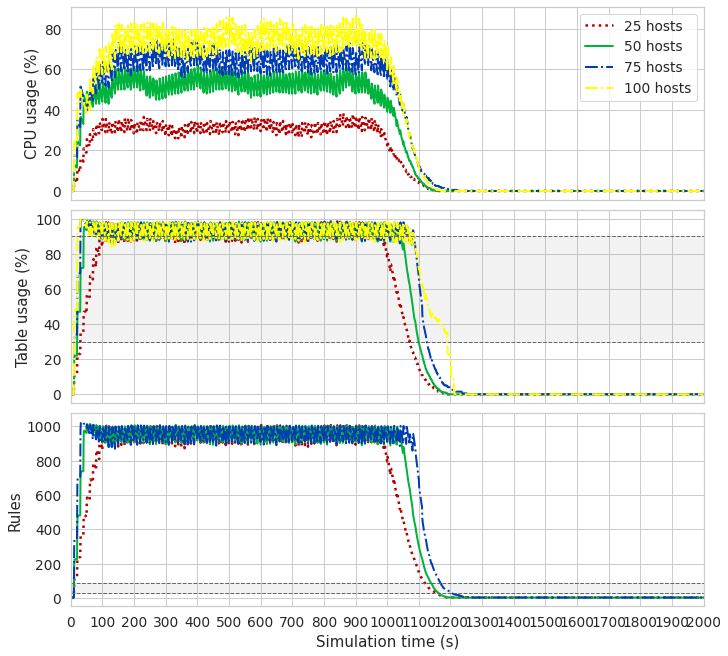

In [7]:
# Criando a figura com seus gráficos e eixo x compartilhado
fig = plt.figure (figsize=(10, 9), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=3, height_ratios=[1, 1, 1])
ax_tab = fig.add_subplot(spec[2])
ax_cpu = fig.add_subplot(spec[1], sharex=ax_tab)
ax_tft = fig.add_subplot(spec[0], sharex=ax_tab)

df_25 = df_hwstats.query ("Carga == '25hosts'")
df_50 = df_hwstats.query ("Carga == '50hosts'")
df_75 = df_hwstats.query ("Carga == '75hosts'")
df_100 = df_hwstats.query ("Carga == '100hosts'")
    
# Linha para o uso de CPU de cada carga
ax_tft.plot ("TimeSec", "LoaUsag", ":",  data=df_25, color="#b30000", label="25 hosts", linewidth=2.5)
ax_tft.plot ("TimeSec", "LoaUsag", "-",  data=df_50, color="#00b33c", label="50 hosts")
ax_tft.plot ("TimeSec", "LoaUsag", "-.", data=df_75, color="#003cb3", label="75 hosts")
ax_tft.plot ("TimeSec", "LoaUsag", "-.", data=df_100, color="#ffff00", label="100 hosts")
  
# Linha para o uso de tabela de cada carga
ax_cpu.plot ("TimeSec", "FloUsag", ":",  data=df_25, color="#b30000", label="25 hosts", linewidth=2.5)
ax_cpu.plot ("TimeSec", "FloUsag", "-",  data=df_50, color="#00b33c", label="50 hosts")
ax_cpu.plot ("TimeSec", "FloUsag", "-.", data=df_75, color="#003cb3", label="75 hosts")
ax_cpu.plot ("TimeSec", "FloUsag", "-.", data=df_100, color="#ffff00", label="100 hosts")

# Thresholds de uso de tabela
ax_cpu.axhspan (ymin=30, ymax=90, color='gray', alpha=0.1)
ax_cpu.axhline (y=30, color="#666666", lw=1, ls="--")
ax_cpu.axhline (y=90, color="#666666", lw=1, ls="--")

# Linha para o numero de regras de cada carga
ax_tab.plot ("TimeSec", "FloEntr", ":",  data=df_25, color="#b30000", label="25 hosts", linewidth=2.5)
ax_tab.plot ("TimeSec", "FloEntr", "-",  data=df_50, color="#00b33c", label="50 hosts")
ax_tab.plot ("TimeSec", "FloEntr", "-.", data=df_75, color="#003cb3", label="75 hosts")

# Thresholds de uso de tabela
ax_tab.axhspan (ymin=30, ymax=90, color='gray', alpha=0.1)
ax_tab.axhline (y=30, color="#666666", lw=1, ls="--")
ax_tab.axhline (y=90, color="#666666", lw=1, ls="--")
    
# Ajuste do eixo y
ax_tft.set_ylabel ("CPU usage (%)", )
ax_cpu.set_ylabel ("Table usage (%)")
ax_tab.set_ylabel ("Rules")
# ax_tft.set_ylim (0.8, 4.2)
# ax_tft.set_ylim (0.9, 4.1)
# ax_cpu.set_ylim (0, 100)
# ax_tab.set_ylim (0, 100)
# ax_tft.set_yticks ([1, 2, 3, 4])
# ax_tft.set_yticklabels (["1", "2", "", "4"])
# ax_cpu.set_yticks (range (0, 101, 25))
# ax_tab.set_yticks (range (0, 101, 25))

# Ajuste do eixo x
ax_tab.set_xlabel ("Simulation time (s)")
ax_tft.tick_params (labelbottom=False)
ax_cpu.tick_params (labelbottom=False)
ax_tab.set_xticks (np.arange(0, t_sim + 1, 100))
ax_tab.set_xlim (0, t_sim)

# Legendas
order = [0, 1, 2, 3]
handles, labels = ax_tft.get_legend_handles_labels()
ax_tft.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right')
   
# Finalizando e retornando a figura
plt.show ()

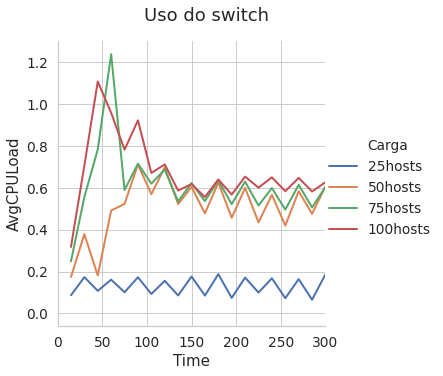

In [8]:
snsplt = sns.relplot(x="Time", y="AvgCPULoad",
            hue="Carga",
            kind="line", legend="full", data=df_plot, ci=None)
snsplt.fig.suptitle('Uso do switch', y=1.05)
snsplt.set(xlim=(0,300))

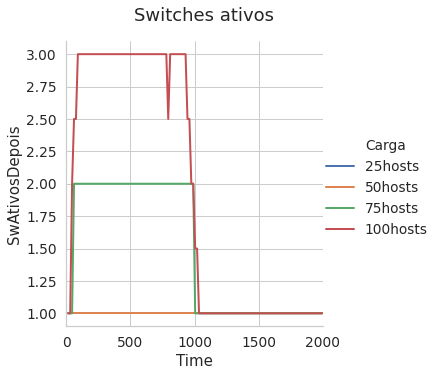

In [9]:
snsplt = sns.relplot(x="Time", y="SwAtivosDepois",
            hue="Carga",
            kind="line", legend="full", data=df_plot, ci=None)
snsplt.fig.suptitle('Switches ativos', y=1.05)
snsplt.set(xlim=(0,2000))